In [16]:
# import를 한다

import os
from glob import glob
import pathlib
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

os.environ['GRPC_VERBOSITY']= 'NONE' # 경고 메시지를 무시하는 부분이다.
os.environ['GLOG_minloglevel']= '2'
os.environ['TF_CPP_MIN_LOG_LEVEL']= '3'
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 이미지를 불러온다.

# root= '/content/drive/MyDrive/DEEP LEARNING/kaggle_3m/TCGA_CS_4941_19960909' #한 폴더만 일단 학습.
# paths_mask= glob(f'{root}/*/*_mask*')
# paths_mask
# paths_imgs= [x.replace('_mask', '') for x in paths_mask] # 파일의 이름이 mask가 붙어있고 없고로 되어있으므로 이렇게 불러옴
# df= pd.DataFrame({'images': paths_imgs, 'masks':  paths_mask,})

directory = "/content/drive/MyDrive/DEEP LEARNING/kaggle_3m/data"

mask_files = glob(f"{directory}/*_mask*")
paths_imgs= [x.replace('_mask', '') for x in mask_files]

df= pd.DataFrame({'images': paths_imgs, 'masks': mask_files ,})
df

# 이미지를 전처리한다
df_trn, df_tmp= train_test_split(df,     test_size=0.2, random_state=42)
df_vld, df_tst= train_test_split(df_tmp, test_size=0.5, random_state=42) #훈련/ 시험 데이터로 분할
df_trn.isna().sum() # 결측 데이터를 확인한다

img_shape= (128, 128, 1) #이미지의 크기를 정해놓는다.
batch_size= 32

def df2gen(gen, df, col, color): #이미지의 컬러모드를 통일하는 함수 두개
    return gen.flow_from_dataframe(df, x_col=col, class_mode=None, color_mode=color, target_size=img_shape[:2], batch_size=batch_size, seed=1)

def gen_create(df, augmentation=dict()):
    gen_img= ImageDataGenerator(**augmentation)
    gen_msk= ImageDataGenerator(**augmentation)

    gen_img= df2gen(gen_img, df, 'images', 'grayscale')
    gen_msk= df2gen(gen_msk, df, 'masks',  'grayscale')

    if not gen_img or not gen_msk:
        return None

    for img, msk in zip(gen_img, gen_msk):
        if img is None or msk is None:
            continue

        if img.shape!=msk.shape:
            print(
                '\033[33mWARNING! shape mismatch!\n\033[0m'+
                'Image shape: ', img.shape,
                'Mask shape:  ', msk.shape,
            )
            #break

        img/= 255
        msk/= 255
        msk[msk>=0.5]= 1
        msk[msk< 0.5]= 0
        yield(img, msk)

gen_trn= gen_create(df_trn, dict(rotation_range=0.2,
                                 width_shift_range=0.05,
                                 height_shift_range=0.05,
                                 zoom_range=0.05,
                                 horizontal_flip=True,
                                 vertical_flip=True))
gen_vld= gen_create(df_vld)
gen_tst= gen_create(df_tst)


# 모델 구조 설정

def unet(nlevels=5):
    downconvs= [None]*nlevels

    inputs= Input(img_shape)

    #Downsampling
    for i in range(2):
        downconvs[0]= Conv2D(128, kernel_size=(3,3), padding='same')(inputs if i==0 else act)
        bn=   BatchNormalization()(downconvs[0])
        act=  Activation('relu')(bn)
    pool= MaxPooling2D((2,2))(act)

    for level in range(1, nlevels):
        for i in range(3):
            downconvs[level]= Conv2D(2**(level+7) if i<2 else 256, kernel_size=(3,3), padding='same')(pool if i==0 else act)
            bn= BatchNormalization()(downconvs[level])
            act= Activation('relu')(bn)
        pool= MaxPooling2D((2,2))(act)

    #Upsampling
    for level in range(nlevels-1, -1, -1):
        up= concatenate([Conv2DTranspose(2**(level+5), kernel_size=(2,2), strides=(2,2), padding='same')(pool if level==nlevels-1 else act), downconvs[level]], axis=3)
        conv= Conv2D(2**(level+8), kernel_size=(3,3), padding='same')(up)
        bn= BatchNormalization()(conv)
        act= Activation('relu')(bn)

    outputs= Conv2D(filters=1, kernel_size=(1,1), activation="sigmoid")(act)
    return Model(inputs=inputs, outputs=outputs)

def dice_coef(y_true, y_pred, smooth=100):
    y_true_flat= K.flatten(y_true)
    y_pred_flat= K.flatten(y_pred)
    intersect= K.sum(y_true_flat*y_pred_flat)
    union= K.sum(y_true_flat)+K.sum(y_pred_flat)
    return (2*intersect+smooth)/(union+smooth)

def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

def iou(y_true, y_pred, smooth=100):
    intersect= K.sum(y_true*y_pred)
    summ= K.sum(y_true+y_pred)
    return (intersect+smooth)/(summ-intersect+smooth)

model= unet()
model.compile(Adamax(learning_rate=1e-3), loss=dice_loss, metrics=['accuracy', iou, dice_coef])
model.summary()

# 모델 학습

steps_per_epoch = len(df_trn) // batch_size + (1 if len(df_trn) % batch_size != 0 else 0)
validation_steps = len(df_vld) // batch_size + (1 if len(df_vld) % batch_size != 0 else 0)

hist= model.fit(gen_trn,
                epochs=50,
                verbose=1,
                validation_data=gen_vld,
                steps_per_epoch= len(df_trn)//batch_size,
                validation_steps=len(df_vld)//batch_size)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 128, 128, 128)  │          1,280 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 128, 128, 128)  │            512 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 128, 128, 128)  │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ activation_19[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 128, 128, 128)  │            512 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 64, 64, 128)    │              0 │ activation_20[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 64, 64, 256)    │          1,024 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_21             │ (None, 64, 64, 256)    │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ activation_21[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 64, 64, 256)    │          1,024 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_22             │ (None, 64, 64, 256)    │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)   

 Total params: 116,994,913 (446.30 MB)

 Trainable params: 116,961,121 (446.17 MB)

 Non-trainable params: 33,792 (132.00 KB)

Found 3070 validated image filenames.
Found 3070 validated image filenames.
Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.8779 - dice_coef: 0.1472 - iou: 0.0838 - loss: -0.1472Found 384 validated image filenames.
Found 384 validated image filenames.
95/95 ━━━━━━━━━━━━━━━━━━━━ 78s 608ms/step - accuracy: 0.8786 - dice_coef: 0.1480 - iou: 0.0843 - loss: -0.1480 - val_accuracy: 0.3756 - val_dice_coef: 0.0246 - val_iou: 0.0126 - val_loss: -0.0246
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 63s 580ms/step - accuracy: 0.9237 - dice_coef: 0.0460 - iou: 0.0290 - loss: -0.0449 - val_accuracy: 0.9890 - val_dice_coef: 0.0147 - val_iou: 0.0124 - val_loss: -0.0147
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 55s 579ms/step - accuracy: 0.9426 - dice_coef: 0.1626 - iou: 0.0938 - loss: -0.1627 - val_accuracy: 0.9895 - val_dice_coef: 0.0135 - val_iou: 0.0133 - val_loss: -0.0135
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 55s 582ms/step - accuracy: 0.9820 - dice_coef: 0.3009 - iou: 0.1882 - loss: -0

In [15]:
# 성능을 확인한다.

def plot_metric(hist, trn_metric, vld_metric, condition):
    trn= hist.history[trn_metric]
    vld= hist.history[vld_metric]
    vld_idx= condition(vld)
    vld_best= vld[vld_idx]
    epochs= list(range(1, len(trn)+1))

    plt.plot(epochs, trn, 'r', label='Training '+trn_metric.title())
    plt.plot(epochs, vld, 'g', label='Validation '+vld_metric.title())
    plt.scatter(vld_idx+1, vld_best, s=150, c='green', label='Best Epoch= %d'%(vld_idx+1))
    plt.title('Training & Validation '+trn_metric.title())
    plt.xlabel('Epochs')
    plt.ylabel(trn_metric.title())
    plt.legend()

plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plot_metric(hist, 'accuracy', 'val_accuracy', np.argmax)
plt.subplot(2, 2, 2)
plot_metric(hist, 'loss', 'val_loss', np.argmin)
plt.subplot(2, 2, 3)
plot_metric(hist, 'iou', 'val_iou', np.argmax)
plt.subplot(2, 2, 4)
plot_metric(hist, 'dice_coef', 'val_dice_coef', np.argmax)
plt.tight_layout()
plt.show()

for _ in range(20):
    index= np.random.randint(1, len(df_tst.index))
    img= cv2.imread(df_tst['images'].iloc[index], 0)
    img= cv2.resize(img, (128, 128))
    img= img/255
    img= img[np.newaxis, :, :, np.newaxis]
    img_pred= model.predict(img)

    plt.figure(figsize=(12, 12))

    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_tst['masks'].iloc[index], 0)))
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(img_pred)>0.5)
    plt.title('Prediction')
    plt.axis('off')

    plt.show()

  # 모델 저장
model.save('20241121_brain_tumor.keras')


Output hidden; open in https://colab.research.google.com to view.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


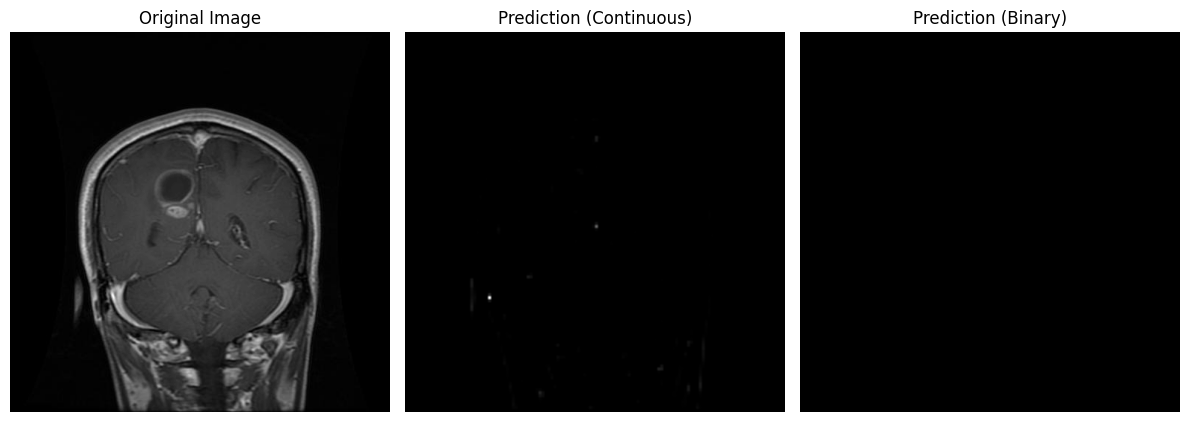

In [14]:
# 원래 모델의 성능이 좋으면, 이제 우리가 사용할 데이터셋을 모델에 넣어본다

from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/20241121_brain_tumor.keras',
                   custom_objects={'dice_loss': dice_loss, 'iou': iou, 'dice_coef': dice_coef})

import cv2
import numpy as np

def preprocess_image(image_path, target_size=(128, 128)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_size)
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)  # (H, W) -> (H, W, 1)
    img = np.expand_dims(img, axis=0)   # (H, W, 1) -> (1, H, W, 1)
    return img

def predict_tumor(model, image_path):
    preprocessed_img = preprocess_image(image_path)
    prediction = model.predict(preprocessed_img)
    binary_mask = prediction > 0.5
    return prediction, binary_mask

import matplotlib.pyplot as plt

def visualize_prediction(image_path, prediction, binary_mask):
    original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(original_img, cmap='gray')
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(prediction), cmap='gray')
    plt.axis('off')
    plt.title('Prediction (Continuous)')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(binary_mask), cmap='gray')
    plt.axis('off')
    plt.title('Prediction (Binary)')

    plt.tight_layout()
    plt.show()

# 새로운 이미지 경로
image_path = '/content/drive/MyDrive/DEEP LEARNING/glioma/Te-gl_0041.jpg'

# 모델 예측
prediction, binary_mask = predict_tumor(model, image_path)

# 결과 시각화
visualize_prediction(image_path, prediction, binary_mask)

#   # 모델 성능이 좋으면 그대로 사용한다

#   # 만약 모델 성능이 좋지 않다면, 새로운 데이터를 모델에 맞도록 전처리 해본다.
#     # 사진의 rgb를 학습하여, rgb 컬러로 변경해주는 모델